<a href="https://colab.research.google.com/github/ebyanuar/Tugas_Akhir/blob/main/TA_Eko_Bagus_Yanuar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistem Deteksi Lubang Dan Keretakan Jalan Pada Mobil Otonom Menggunakan Algoritma Convolutional Neural Network

## Latar Belakang:


Permukaan jalan terus-menerus mengalami kerusakan yang diakibatkan dari lalu lintas yang padat, volume kendaraan berat, dan kondisi cuaca basah. Kondisi jalan yang rusak mengakibatkan kemacetan, keamanan kendaraan dan pengemudi, dan penurunan kualitas suspensi kendaraan (Anand et al., 2019). Kerusakan yang banyak ditemukan di jalan yaitu lubang dan retakan sehingga dapat mengancam kendaraan karena tidak manuver tepat waktu. Tugas menghindar ini ditangani oleh pengemudi yang berpengalaman. Akan tetapi seiring munculnya mobil otonom, sangat penting untuk membuat sistem otomatis yang dapat mendeteksi kerusakan permukaan jalan untuk meningkatkan kinerja kendaraan dan kenyamanan penumpang (Hasan et al., 2020).
Mobil otonom atau kendaraan tanpa kendali merupakan pembaruan yang tercipta dari perkembangan teknologi komputasi yang canggih. Mobil otonom ini beroperasi seminimal mungkin bekerja tanpa campur tangan manusia. Tujuan utamanya adalah mengurangi kecelakaan lalu lintas yang diakibatkan kelalaian pengemudi seperti mengantuk dan sebagainya. Agar dapat bekerja secara otomatis, mobil otonom biasanya banyak menggunakan kombinasi teknologi sensor dan kamera. Kamera ini bertindak sebagai indra yang nantinya dikomputasi ke algoritma tertentu melalui computer vision (Uijlings et al., 2013).

## Deep Learning

Ini adalah masalah Deteksi objek, membuat kumpulan data dengan mengambil gambar jalan, beri anotasi pada gambar dengan menggambar bounding box di sekelilingnya. Train model deteksi Objek sehingga diberi gambar input, identifikasi/klasifikasikan sebagai lubang atau tidak dan jika mengandung lubang, program akan dideploy menggunakan flask.

## Performance Metrics:

* Mean Average Precision (MaP
* Intersection Over Union (IOU)

## Data Gambar:

Data didapat dari [kaggle](https://www.kaggle.com/sovitrath/road-pothole-images-for-pothole-detection), S. Nienaber, M.J. Booysen, and R.S. Kroon.

In [ ]:
# Importing libraries

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

In [ ]:
data_dir = 'Mydrive/data' # folder data

# print semua data didalam folder
print(os.listdir(data_dir))

['train_df.csv', '.ipynb_checkpoints', 'Train data', 'Test data']


In [ ]:
def get_file_path_df(folder):
  """
  Berfungsi untuk mendapatkan jalur file .jpg di folder yang ditentukan,
  mengambil input folder dan mengembalikan pandas dataframe
  """
  image_path = [] 
  for root, dirs, files in os.walk(folder):
    for f in files:
      if f.endswith(".JPG"): # cek file format .JPG 
        image_path.append(os.path.join(root, f)) # menambahkan ke list image_path
  # df = dataframe
  df_cols = {'path': image_path} # membuat data dictionary
  df = pd.DataFrame(df_cols) # membuat dataframe
  return df

In [ ]:
# mendapatkan path absolut dari semua gambar dan menyimpannya dalam dataframe data_df
data_df = get_file_path_df(data_dir)

# menampilkan data 5 teratas
data_df.head()
data_df.to_csv('TA_yanuar_Data.csv', index=False)

In [ ]:
data_df.shape

(2674, 1)

### Observations:
* Data contains 2674 images

In [ ]:
def get_train_test_df(data_frame):
  """
  Fungsi untuk menambahkan dataframe train dan test
  mengambil input dataframe dan mengembalikan dataframe train dan test
  """
  train_path = []
  train_label = []
  test_path = []

  for path in data_frame['path'].values:
    # memisahkan path '/' (cth: data/Train data/Positive data/G0027850.JPG) 
    path_split = path.split('/') 
    data_type = path_split[1] # mengakses nama folder di colab

    if data_type == 'Train data': 
      # gambar untuk data train
      train_path.append(path)
      train_label.append(path_split[2]) # appending label
    else:
      # gambar untuk data test
      test_path.append(path)
    
  # membuat dict dari train data
  train_dict = df_cols = {'path': train_path, 'label': train_label} 
  train_df = pd.DataFrame(train_dict) # membuat train dataframe

  test_dict = {'path': test_path} # membuat dict untuk test data
  test_df = pd.DataFrame(test_dict) # membuat test dataframe
  return train_df, test_df

In [ ]:
# membuat dataframe train, test, dan validasi
train_df, test_df = get_train_test_df(data_df)

In [ ]:
# train dataframe
train_df.sample(5)

path          label
1262  data/Train data/Positive data/G0030286.JPG  Positive data
322   data/Train data/Negative data/G0027204.JPG  Negative data
1396  data/Train data/Positive data/G0089517.JPG  Positive data
150   data/Train data/Negative data/G0027953.JPG  Negative data
565   data/Train data/Negative data/G0066232.JPG  Negative data

In [ ]:
# test dataframe
test_df.sample(5)

path
6    data/Test data/G0027191.JPG
247  data/Test data/G0027958.JPG
98   data/Test data/G0024750.JPG
64   data/Test data/G0041758.JPG
104  data/Test data/G0026516.JPG

## EDA:

### Data distribution

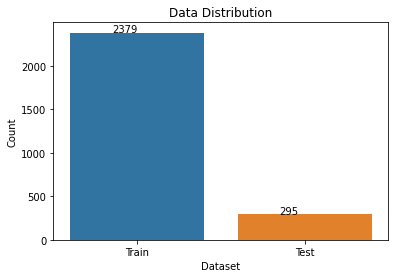

In [ ]:
# visualisasi distribusi data train and test

# membuat bar plot
plot = sns.barplot(['Train', 'Test'], 
                   [train_df.shape[0], test_df.shape[0]])
plt.title('Data Distribution')
plt.xlabel('Dataset')
plt.ylabel('Count')

# menambahkan perhitungan masing-masing data
for patch in plot.patches:
    # format dari hasil perhitungan
    plot.annotate('{:n}'.format(patch.get_height()), 
                  (patch.get_x()+0.25, patch.get_height()+1)) 
plt.show()

#### Observations:
* Data contains 3777 training images
* Data contains 628 test images

### Class distribution

In [ ]:
def get_class_distrib(df):
  """
  fungsi untuk mendapatkan distribusi kelas dalam dataset
  mengambil dataframe input dan memplot distribusi kelas
  """
  label_count = df['label'].value_counts()
  plot = sns.barplot(list(label_count.index), list(label_count.values))
  plt.title('Class Distribution')
  plt.xlabel('Class Label')
  plt.ylabel('Count')

  # menambahkan perhitungan kelas dalam barplot
  for patch in plot.patches:
      # format hasil perhitungan
      plot.annotate('{:n}'.format(patch.get_height()), 
                    (patch.get_x()+0.25, patch.get_height()+1)) 
  plt.show()


Class distribution of training data


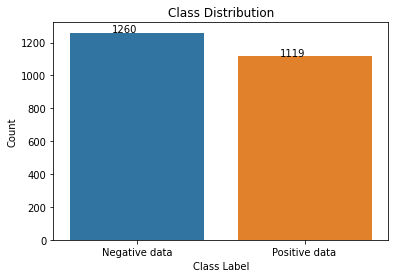

In [ ]:
print("Class distribution of training data")
get_class_distrib(train_df)

### Observations:
* Data contains 1119 images with potholes
* Data contains 2658 images without potholes

### Image height & width distribution

In [ ]:
def get_image_size_distrib(df):
  """
  fungsi untuk menambahkan tinggi dan lebar gambar
  mengambil datafame input
  output = rata-rata panjang dan lebar gambar
  """
  
  heights = []
  widths = []

  for path in df['path'].values:
          # img = cv2.imread(os.path.join(img_dir, path))
          img = cv2.imread(path) 
          shape = img.shape # (h, w, d) = image.shape
          heights.append(shape[0])
          widths.append(shape[1]) 

  plt.figure(figsize=(10,3))
  sns.distplot(heights)
  plt.title('Image height distribution')
  plt.xlabel('Height')
  plt.show()
  height_median = np.median(heights)
  print('Median height:', height_median)
  height_mean = np.mean(heights)
  print('Mean height:', height_mean)
  print()
  plt.figure(figsize=(10,3))
  sns.distplot(widths)
  plt.title('Image width distribution')
  plt.xlabel('Width')
  plt.show()
  width_median = np.median(widths)
  print('Median width:', width_median)
  width_mean = np.mean(widths)
  print('Mean width:', width_mean)


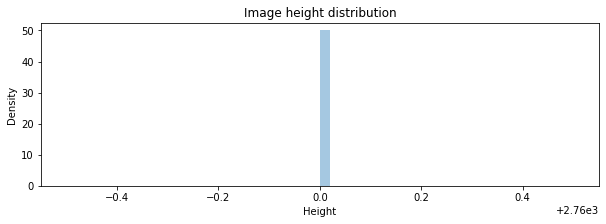

Median height: 2760.0
Mean height: 2760.0



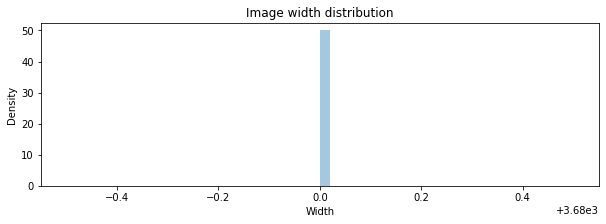

Median width: 3680.0
Mean width: 3680.0


In [ ]:
get_image_size_distrib(data_df)

#### Obsesrvations:
* All the images are of same size
* image height = 2760 pixel
* image width = 3680 pixel


### Image Annotations (Bounding Box)

In [ ]:
# anotasi data (bounding box)

annotation_df = pd.read_csv(os.path.join(data_dir, 'train_df.csv'))
annotation_df.head()

image_id  num_potholes     x     y    w   h
0  G0010033             6  1990  1406   66  14
1  G0010033             6  1464  1442   92  16
2  G0010033             6  1108  1450   54  16
3  G0010033             6   558  1434  102  16
4  G0010033             6   338  1450   72  18

### Observations:
* column details:
    * num_potholes: number of the potholes in an image
    * x: upper left corner coordinate
    * y: upper left corner coordinate
    * w: width of the pothole
    * h: height of the pothole

### Visualizing the data

In [ ]:
def visualize_data(img_df, annot_df, data_type):
  """
  fungsi untuk visualisasi gambar
  mengambil dataframe gambar, dataframe BBox, dan input data_type
  jika tipe data adalah test, maka menampilkan gambar tanpa label,
  selain itu cetak dengan label BBOx
  """
  
  rows = np.random.randint(img_df.shape[0], size=5) # generate 5 angka
  sample_imgs = img_df.iloc[rows, :] # gambar random

  counter = 0
  plt.figure(figsize = (12, 50))

  # cek data_type = test
  if data_type.lower() == 'test':
      for idx, row in sample_imgs.iterrows():
        path = row['path'] # file path
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED) # reading the image
        plt.subplot(5, 1, 1 + counter)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        counter += 1
  else:
      for idx, row in sample_imgs.iterrows():
        # file path
        path = row['path']  #(data/Train data/Positive data/G0027850.JPG
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED) # reading the image
        lab = row['label'] # file label
        coords = [] # BBox coordinates
        # if the image contains potholes
        if lab == 'Positive data':
          lab = 'Pothole'
          img_id = path.split('/')[-1]
          img_id = img_id.split('.')[0]
          coords = annot_df[annot_df['image_id'] == img_id]
          coords = coords[['x', 'y', 'w', 'h']].values
        else:
          lab = 'No Pothole' 

        plt.subplot(5, 1, 1 + counter)
        plt.title(lab)
        plt.xticks([])
        plt.yticks([])
        # drawing BBoxes
        for c in coords:
          cv2.rectangle(img, (c[0], c[1]), (c[0]+c[2], 
                            c[1]+c[3]), (255, 0, 0), 3)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        counter += 1
  plt.show()

#### Training data

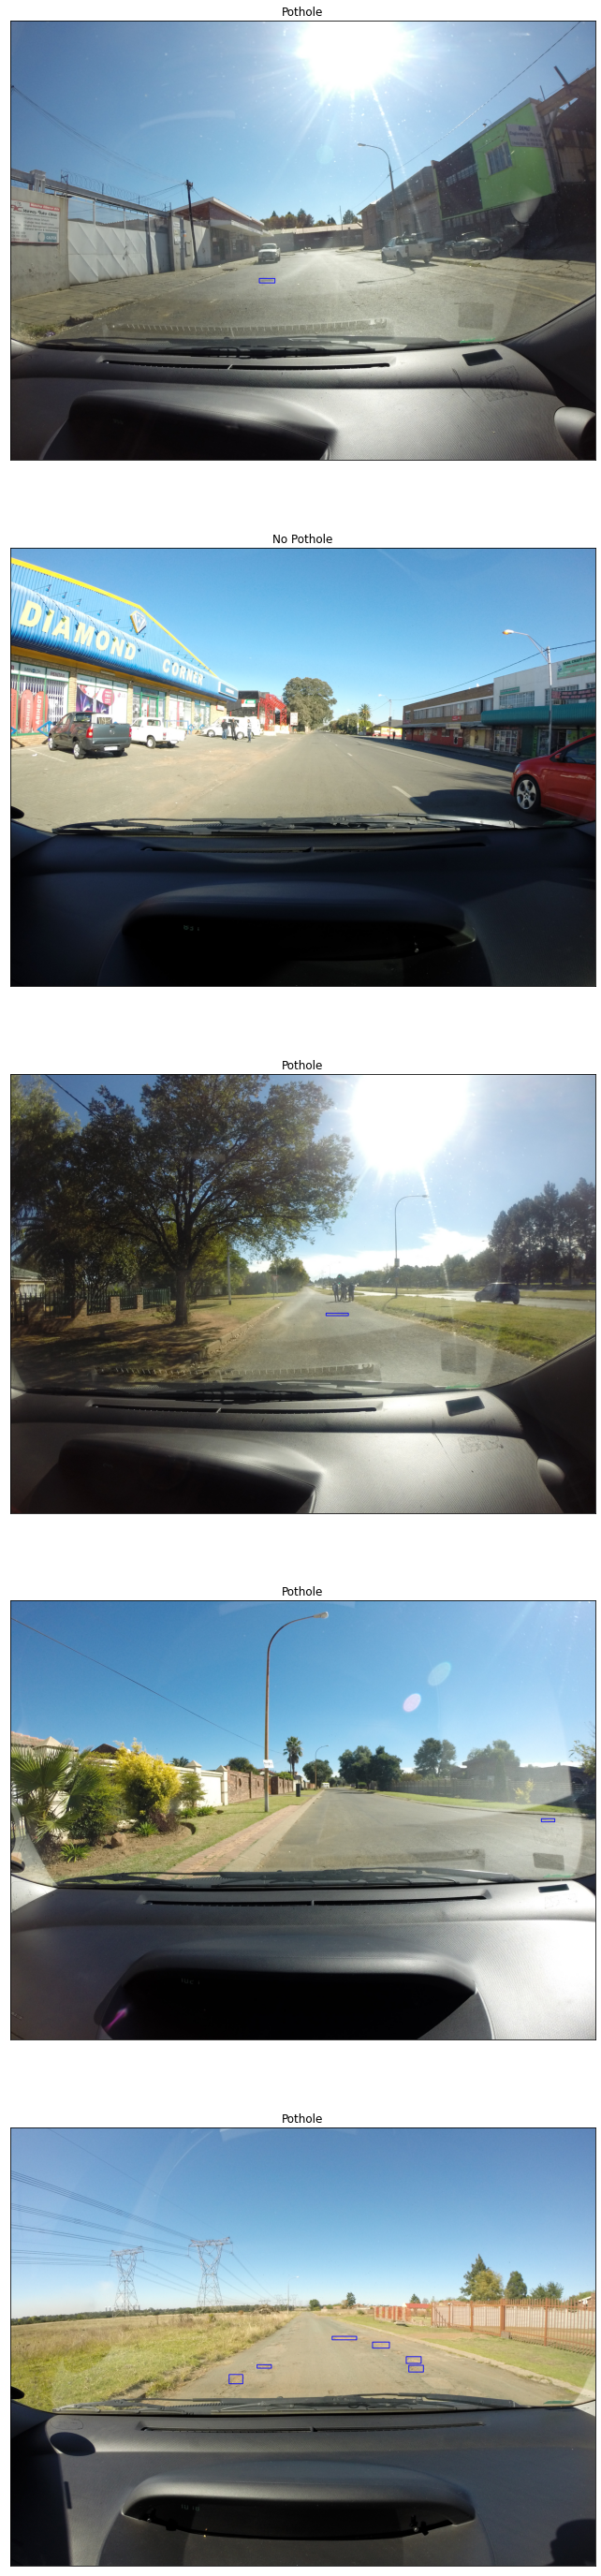

In [ ]:
# visualizing train data
visualize_data(train_df, annotation_df, 'Train')

#### Test data

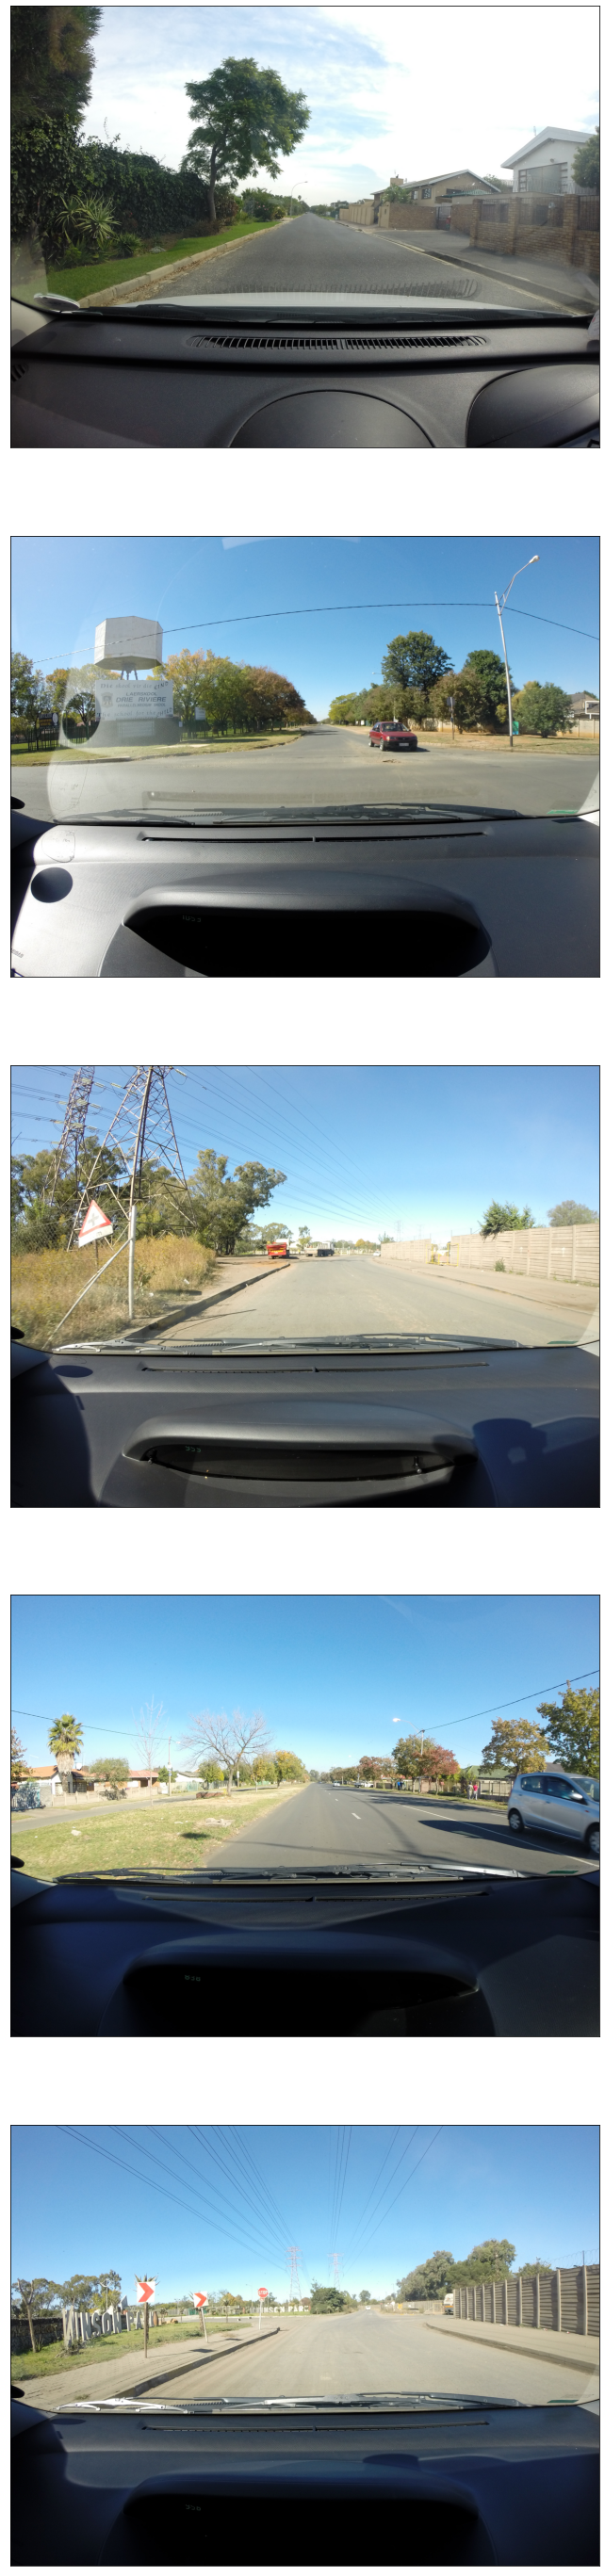

In [ ]:
# visualizing test data
visualize_data(train_df, annotation_df, 'Test')

### Kesimuplan EDA:


* Data mengandung 4405 gambar, dimana 3777 gambar termasuk training set dan 628 gambar termasuk test set
* Data training berisi 2 kelas yaitu Positif (berlubang) dan Negatif (Tidak berlubang)
* 1119 gambar train termasuk dalam kelas positif dan 2658 gambar termasuk dalam kelas negatif
* Semua gambar berukuran sama dengan tinggi 2760 piksel dan lebar 3680 piksel

## Preprocessing

Untuk pemrosesan data untuk di-train

In [ ]:
# Importing libraries

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import cv2

from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import imageio

In [ ]:
data_dir = 'data' # data directory

# printing all the folders/files within the data directory
print(os.listdir(data_dir))

In [ ]:
def get_file_path_df(folder):
  """
  Function to get path of .jpg files in the specified folder
  takes folder input and returns pandas dataframe
  """
  image_path = [] 
  for root, dirs, files in os.walk(folder):
    for f in files:
      if f.endswith(".JPG"): # checking for JPG extension 
        image_path.append(os.path.join(root, f)) # appending to image_path list
  # df = dataframe
  df_cols = {'path': image_path} # creating a dictionary
  df = pd.DataFrame(df_cols) # creating a dataframe
  return df

In [ ]:
# getting absolute path of all images and storing in a dataframe called data_df
data_df = get_file_path_df(data_dir)

# displying random 5 rows
data_df.sample(5)

In [ ]:
data_df.shape

### Data preprocessing

In [ ]:
# plot an image randomly

row = np.random.randint(data_df.shape[0], size=1)[0]
sample_img = data_df.iloc[row, :]

plt.figure(figsize = (12, 50))
path = sample_img['path'] # image path
img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.yticks(np.arange(0, img.shape[0], 100))
plt.show()

#### Observasi

* From the above plot we can see that our area of interest lies in the range of 0 to 1800 pixel along y axis
* Image part greater than 1800 pixel contains car dashboard, there is chance of model recognizing it as a pothole
* Also it simply increases the computation time so lets remove it

In [ ]:
# annotation data (bounding boxes)

annotation_df = pd.read_csv(os.path.join(data_dir, 'train_df.csv'))
annotation_df.head()

In [ ]:
annotation_df.shape

In [ ]:
# remove duplicates if exists
annotation_df.drop_duplicates(keep='first', inplace=True)
annotation_df.reset_index(inplace=True, drop=True)
annotation_df.head()

In [ ]:
annotation_df.shape

In [ ]:
# add x_max and y_max columns (right extreme point)

annotation_df['x_max'] = annotation_df['x'] + annotation_df['w']
annotation_df['y_max'] = annotation_df['y'] + annotation_df['h']
print("Data frame after updating columns")
print()
annotation_df.head()

In [ ]:
annotation_df.to_csv('test.csv', index=False)

In [ ]:
# maximum right exterme y cooridinate
y_max = annotation_df['y_max'].values.max()
print('Maximum value of y-coordinate of a BBox:', y_max)

In [ ]:
# lets check the percentile values of y coordinate

# print 0 to 100 percentile values of BBox (y_coord + height) with step size of 10. 
for i in range(0,100,10):
    # var = annotation_df['y'].values + annotation_df['h'].values
    var = annotation_df['y_max'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

In [ ]:
## print 90 to 100 percentile values of BBox (y_coord + height) with step size of  1. 

for i in range(90,100,1):
    # var = annotation_df['y'].values + annotation_df['h'].values
    var = annotation_df['y_max'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

In [ ]:
y_max = 1964

In [ ]:
# remove all the bounding boxes having y coordinate greater than 1976 pixel
annotation_df_new = annotation_df[annotation_df['y_max'] <= y_max]
annotation_df_new.head()

In [ ]:
annotation_df_new.shape

In [ ]:
def crop_imgs(data_frame, y_crop):
    """ 
    Function to crop images
    Input: 
    1. data frame containing path info
    2. y coordinate value to crop
    Output:
    Cropped images
    """
    # drictories to store the cropped images
    dirs = ['processed_data/train/positive',
            'processed_data/train/negative',
            'processed_data/test']

    # if folder does not exist create them
    for d in dirs:
        if not os.path.exists(d):
                os.makedirs(d)

    # loop over each image and crop them
    for path in data_frame['path'].values:
        path_split = path.split('/') 
        data_type = path_split[1] # accessing folder name
        img_type = path_split[2] # image type (positive/negative)
        img_id = path_split[-1]

        if data_type == 'Train data': # if data belong to trainset
            if img_type == 'Positive data':
                img_type_new = 'positive'
            else: 
                img_type_new = 'negative'
            new_path = f'processed_data/train/{img_type_new}/{img_id}'
        else:
            new_path = f'processed_data/test/{img_id}'

        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        img_crop = img[:y_crop+1, :] # cropping
        cv2.imwrite(new_path, img_crop)
    print("Done")

In [ ]:
%%time
crop_imgs(data_df, y_max)

In [ ]:
processed_data_dir = 'processed_data' # data directory

# printing all the folders/files within the data directory
print(os.listdir(processed_data_dir))

In [ ]:
# getting absolute path of all images and storing in a dataframe called processed_data_df
processed_data_df = get_file_path_df(processed_data_dir)

# displying random 5 rows
processed_data_df.sample(5)

In [ ]:
processed_data_df.shape

In [ ]:
def get_train_test_df(data_frame):
  """
  Function to get train and test dataframe
  takes dataframe input and returns train, and test dataframe
  """
  train_path = []
  train_label = []
  test_path = []

  for path in data_frame['path'].values:
    # splitting the path by '/' (eg: data/Train data/Positive data/G0027850.JPG) 
    path_split = path.split('/') 
    data_type = path_split[1] # accessing folder name

    if data_type == 'train': 
      # train images
      train_path.append(path)
      train_label.append(path_split[2]) # appending label
    else:
      # test images
      test_path.append(path)
    
  # creating dictionary of train data
  train_dict = {'path': train_path, 'label': train_label} 
  train_df = pd.DataFrame(train_dict) # creating train dataframe

  test_dict = {'path': test_path} # creating dictionary of test data
  test_df = pd.DataFrame(test_dict) # creating test dataframe
  return train_df, test_df

In [ ]:
# creating train and test dataframe
processed_train_df, processed_test_df = get_train_test_df(processed_data_df)

In [ ]:
processed_train_df.shape

In [ ]:
processed_test_df.shape

In [ ]:
tot_neg = processed_train_df['label'].value_counts()['negative']
tot_pos = processed_train_df['label'].value_counts()['positive']

imbalance = abs(tot_pos - tot_neg)
imbalance

In [ ]:
# This setup of augmentation parameters will pick two of five given 
# augmenters and apply them in random order

augmentor = iaa.SomeOf(2, [    
    iaa.Affine(scale=(0.8, 1.2)),
    iaa.Affine(rotate=(-20, 20)),
    iaa.Fliplr(1),
    iaa.Affine(shear=(-5, 5)),
    iaa.GaussianBlur(sigma=(1.0, 3.0)),
    iaa.GammaContrast((0.6, 1.5))
])

In [ ]:
def augment_img_bbox(annot_df, path, augmentor, img_id, suffix):
        """ 
        Function to augment images and corresponding bounding boxes
        Inputs:
                1. annot_df: Bounding box coordinates
                2. path: image path
                3. augmentor: set of data augmentors
                4. img_id: image id
        Output:
                Data frame containing augmented BBox coordinates

        Reference:https://medium.com/@a.karazhay/guide-augment-images-
        and-multiple-bounding-boxes-for-deep-learning-in-4-steps-with-the-
        notebook-9b263e414dac
        """
        # details of an image to augment
        bbox_coords = annot_df[annot_df['image_id'] == img_id]

        # BBox coordinates of an orginal image
        bb_array = bbox_coords.loc[:, ['x', 'y', 'x_max', 'y_max']].values
        # read an image
        image = imageio.imread(path)

        bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)

        # image and BBox after applying augmentation
        image_aug, bbs_aug = augmentor(image=image, bounding_boxes=bbs)
        # disregard bounding boxes which have fallen out of image pane    
        bbs_aug = bbs_aug.remove_out_of_image()
        # clip bounding boxes which are partially outside of image pane
        bbs_aug = bbs_aug.clip_out_of_image()

        path = path.split('/')[:-1]
        path = ('/').join(path)

        # save augmented image
        imageio.imwrite(f'{path}/{img_id}_{suffix}.JPG', image_aug)
        # convert bounding boxes to an array
        bbs_array = bbs_aug.to_xyxy_array()
        img_id_array = np.empty([bbs_array.shape[0], 1])
        # concatinate image_id and BBox coordinate
        final = np.concatenate((img_id_array, bbs_array), axis=1)
        # create a data frame
        df = pd.DataFrame(final, columns=['image_id', 'x', 'y', 'x_max', 'y_max'])
        df['image_id'] = f'{img_id}_{suffix}'
                
        return df

In [ ]:
def augment_data(train_img_df, annot_df, augmentor, num_sample):
    """ 
    Function to augment data
    Inputs:
        1. train_img_df: images to augment
        2. annot_df: Bounding box data frame
        3. augmentor: set of data augmentors
        4: num_sample: number of sambles to augment
    Output:
        Data frame containing augmented BBox coordinates
    """
    # initialize empty data frame
    final_df = pd.DataFrame()

    for i in range(num_sample):
        pos = False

        # repeat until find an image with potholes
        while not pos:
            idx = np.random.randint(train_img_df.shape[0], size=1)[0]
            row = train_img_df.iloc[idx, :]
            path = row['path']
            path = train_img_df['path'][idx]
            path_split = path.split('/')
            sample_type = path_split[-2]
            if sample_type == 'positive':
                pos = True

        img_id = path_split[-1]
        img_id = img_id.split('.')[0]
        # augment the image and corresponding BBoxes
        df = augment_img_bbox(annot_df, path, augmentor, img_id, i)

        final_df = pd.concat([final_df, df], ignore_index=True)

    return final_df

In [ ]:
%%time

augmented_BBox_df1 = augment_data(processed_train_df, annotation_df_new, augmentor, imbalance)

In [ ]:
augmented_BBox_df1.shape

In [ ]:
# concatinate augmented images BBox coordinates
aug_BBox = annotation_df_new.drop(['num_potholes', 'w', 'h'], axis=1)
augmented_BBox_df = pd.concat([aug_BBox, augmented_BBox_df1], ignore_index=True)
augmented_BBox_df.head()

In [ ]:
augmented_BBox_df.shape

In [ ]:
# save csv file containing all the BBox coordinates
augmented_BBox_df.to_csv("augmented_BBox_df.csv", index=False)

In [ ]:
processed_data_dir = 'processed_data' # data directory

processed_data_df = get_file_path_df(processed_data_dir)
processed_train_df, processed_test_df = get_train_test_df(processed_data_df)

# creating a bar plot
plot = sns.barplot(['Train', 'Test'], 
                   [processed_train_df.shape[0], processed_test_df.shape[0]])
plt.title('Data Distribution')
plt.xlabel('Dataset')
plt.ylabel('Count')

# adding class count to the barplot
for patch in plot.patches:
    # formatting and positioning the count values
    plot.annotate('{:n}'.format(patch.get_height()), 
                  (patch.get_x()+0.25, patch.get_height()+1)) 
plt.show()

In [ ]:
def get_class_distrib(df):
  """
  Function to get class distribution within a dataset
  takes dataframe input and plots the class distribtution
  """
  label_count = df['label'].value_counts()
  plot = sns.barplot(list(label_count.index), list(label_count.values))
  plt.title('Class Distribution')
  plt.xlabel('Class Label')
  plt.ylabel('Count')

  # adding class count to the barplot
  for patch in plot.patches:
      # formatting and positioning the count values
      plot.annotate('{:n}'.format(patch.get_height()), 
                    (patch.get_x()+0.25, patch.get_height()+1)) 
  plt.show()


In [ ]:
print("Class distribution of training data")
get_class_distrib(processed_train_df)

In [ ]:
import random
import imgaug as ia
folder_old = 'data/Train data/Positive data'
folder_new = 'processed_data/train/positive'

In [ ]:
def get_image_BBox(path, annot_df, img_id):
  """
  Function reads an image & return corresponding BBox coordinates
  Inputs:
    1. path: image path
    2. annot_df: BBox data frame
    3. img_id: image id
  Output: 
    image and corresponding BBox coordinates
  """
  # read an image
  image = imageio.imread(path)

  # extract BBox coordinates from a data frame
  bbox_coords = annot_df[annot_df['image_id'] == img_id]
  bbox_coords = bbox_coords[['x', 'y', 'x_max', 'y_max']].values
  bbox_coords = BoundingBoxesOnImage.from_xyxy_array(bbox_coords, shape=image.shape)

  return image, bbox_coords

In [ ]:
def visualize_data(img_dir_old, annot_df_old, img_dir_new, annot_df_new):
    """
    Function to visualize images before and after augmentation
    Inputs:
        1. img_dir_old: directory of images
        2. annot_df_old: BBox data frame
        3. img_dir_new: directory of augmented images
        4. annot_df_new: BBox data frame of augmented images
    Outputs:
        image & augmented image
    """

    # 5 random images
    smpls = random.sample(os.listdir(img_dir_old), 5)

    plt.figure(figsize = (6, 25))
    
    for old_img in smpls:
        # image path
        old_path = f'{img_dir_new}/{old_img}'
        # image id
        old_img_id = old_img.split('.')[0]
        f = ''
        for file in os.listdir(img_dir_new):
            split_name = file.split('_')
            
            if len(split_name) <= 1:
                continue
            else:
                if split_name[0] == old_img_id:
                    f = file
                    break
        if f:
            new_path = f'{img_dir_new}/{f}'
            new_img_id = f.split('.')[0]
        else:
            new_path = old_path
            new_img_id = old_img_id
            
        print(old_path)
        print(new_path)

        # image and corresponding BBoxes
        img_old, bbox_old = get_image_BBox(old_path, annot_df_old, old_img_id)
        img_new, bbox_new = get_image_BBox(new_path, annot_df_new, new_img_id)

        ia.imshow(np.hstack([
            bbox_old.draw_on_image(img_old, size=10, color=[0, 0, 255]),
            bbox_new.draw_on_image(img_new, size=10, color=[0, 0, 255])
            ]))

In [ ]:
visualize_data(folder_old, annotation_df_new, folder_new, augmented_BBox_df)

## train SSD MobileNet

**Environment Setup**

Install tensorflow v1.14

In [ ]:
# check tensorflow version
import tensorflow as tf
print(tf.__version__)

In [ ]:
# Colab default version is now 2.6.0, so uninstall it and install v1.14

%tensorflow_version 2.x
!pip uninstall -y tensorflow tensorboard tensorflow-estimator tensorboard-plugin-wit
!pip install tensorflow-gpu==1.14.0 tensorboard==1.14.0 tensorflow-estimator==1.14.0 

In [ ]:
# tensorflow version

import tensorflow as tf
print(tf.__version__)

Install necessary libraries

In [ ]:
# install necessary libraries

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -q pillow lxml jupyter matplotlib cython pandas contextlib2
!pip install -q pycocotools tf_slim

Install necessary libraries

In [ ]:
#mount google drive

from google.colab import drive
drive.mount('/content/gdrive')

Create a project folder inside the drive

In [ ]:
# create a folder 'pothole' inside My Drive and navigate to it
%cd /content/gdrive/My Drive/pothole 

Clone tensorflow 1 object detection api

In [ ]:
# clone tensorflow 1 object detection api
!git clone --quiet -b r1.13.0 https://github.com/tensorflow/models.git

Compile protos

In [ ]:
#navigate to /content/gdrive/My Drive/pothole/models/research folder 
%cd /content/gdrive/My Drive/pothole/models/research
 
# compile protos
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/gdrive/My Drive/pothole/models/research/:/content/gdrive/My Drive/pothole/models/research/slim/'

!pip install .

Test installation

In [ ]:
# Test installation
!python object_detection/builders/model_builder_test.py

COCO API Installation

In [ ]:
#navigate to /content/gdrive/My Drive/pothole/ folder
%cd /content/gdrive/My Drive/pothole/

# clone cocoapi
!git clone --quiet https://github.com/cocodataset/cocoapi.git

Build makefile

In [ ]:
# navigate to the folder PythonAPI
%cd /content/gdrive/My Drive/pothole/cocoapi/PythonAPI

# build makefile
!make

In [ ]:
# copy the folder pycocotools to the location '/content/gdrive/MyDrive/pothole/models/research/'
!cp -r pycocotools /content/gdrive/MyDrive/pothole/models/research/

#### Download Pretrained Model
* Create 'training' directory
* Navigate in to 'training' folder and create the folder 'pre-trained-models'

In [ ]:
%cd /content/gdrive/My Drive/pothole/training/pre-trained-models

##### Download the pretrained ssd_mobilenet from [TF1 Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md)

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz

Extract contents of ssd_mobilenet

In [ ]:
!tar -xvf ssd_mobilenet_v2_coco_2018_03_29.tar.gz

#### Data Preprocessing

* Create 'images' folder and navigate into it


In [ ]:
# navigate to images folder
%cd /content/gdrive/My Drive/pothole/training/images

In [ ]:
# unzip train.zip
!unzip train.zip

# unzip test.zip
!unzip test.zip

Convert .xml files to csv

In [ ]:
# Create train data:
!python scripts/xml_to_csv.py -i images/train -o annotations/train_labels.csv

# Create test data:
!python scripts/xml_to_csv.py -i images/test -o annotations/test_labels.csv

create label map file

In [ ]:
# create lable_map.pbtxt as shown 
# place it in annotations folder
!cat annotations/label_map.pbtxt

Create train.record and test.record files

In [ ]:
# Create train data:
!python scripts/generate_tfrecord_v1.py \
    --csv_input=annotations/train_labels.csv \
    --output_path=annotations/train.record \
    --img_path=images/train \
    --label_map annotations/label_map.pbtxt

# Create test data:
!python scripts/generate_tfrecord_v1.py \
    --csv_input=annotations/test_labels.csv \
    --output_path=annotations/test.record \
    --img_path=images/test \
    --label_map annotations/label_map.pbtxt

#### Training

Tensorboard

In [ ]:
# track training usnig tensorboard

%load_ext tensorboard
%tensorboard --logdir='/content/gdrive/MyDrive/pothole/training/my_ssd_mobilenet_v2_coco_2018_03_29'

##### edit pipiline.config file 
* Note: please remove the line 'batch_norm_trainable: true' from config file

In [ ]:
# navigate to pre-trained-models/ssd_mobilenet_v2_coco_2018_03_29
%cd /content/gdrive/My Drive/pothole/training/pre-trained-models/ssd_mobilenet_v2_coco_2018_03_29

# copy the pipiline.config file 
!cp -r pipeline.config /content/gdrive/MyDrive/pothole/training/models/my_ssd_mobilenet_v2_coco_2018_03_29/

In [ ]:
# edit the pipline.config file as shown
!cat /content/gdrive/MyDrive/pothole/training/models/my_ssd_mobilenet_v2_coco_2018_03_29/pipeline2.config

In [ ]:
# training

!python /content/gdrive/MyDrive/pothole/models/research/object_detection/model_main.py \
    --pipeline_config_path=/content/gdrive/MyDrive/pothole/training/models/my_ssd_mobilenet_v2_coco_2018_03_29/pipeline.config \
    --model_dir=/content/gdrive/MyDrive/pothole/training/my_ssd_mobilenet_v2_coco_2018_03_29 \
    --alsologtostderr

In [ ]:
# continue training

!python /content/gdrive/MyDrive/pothole/models/research/object_detection/model_main.py \
    --pipeline_config_path=/content/gdrive/MyDrive/pothole/training/models/my_ssd_mobilenet_v2_coco_2018_03_29/pipeline.config \
    --model_dir=/content/gdrive/MyDrive/pothole/training/my_ssd_mobilenet_v2_coco_2018_03_29 \
    --alsologtostderr

####Training Result

#### Prediction

Export the trained model

In [ ]:
# Reference: https://towardsdatascience.com/object-detection-by-tensorflow-1-x-5a8cb72c1c4b

import os
import re
import numpy as np

# train logs
model_dir = '/content/gdrive/MyDrive/pothole/training/my_ssd_mobilenet_v2_coco_2018_03_29'

# get latest model check point
lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

In [ ]:
# export the model
!python /content/gdrive/MyDrive/pothole/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/gdrive/MyDrive/pothole/training/models/my_ssd_mobilenet_v2_coco_2018_03_29/pipeline.config \
    --output_directory=/content/gdrive/MyDrive/pothole/training/final_model \
    --trained_checkpoint_prefix={last_model_path}

##### Set images for the inference

In [ ]:
IMAGE_DIR = '/content/gdrive/MyDrive/pothole/training/test_images'
IMAGE_PATHS = []

for file in os.listdir(IMAGE_DIR):
    if file.endswith(".JPG"):
        IMAGE_PATHS.append(os.path.join(IMAGE_DIR, file))

IMAGE_PATHS

In [ ]:
# label_map path
PATH_TO_LABELS = '/content/gdrive/MyDrive/pothole/training/annotations/label_map.pbtxt'

In [ ]:
# model check point path
output_dir = '/content/gdrive/MyDrive/pothole/training/final_model'
PATH_TO_CKPT = os.path.join(os.path.abspath(output_dir), "frozen_inference_graph.pb")

In [ ]:
# test image bounding boxes
import pandas as pd
img_bbox_df = pd.read_csv('/content/gdrive/MyDrive/pothole/training/test_images/test_bboxes_tf.csv')
img_bbox_df.head()

Inference

In [ ]:
# Reference: https://towardsdatascience.com/object-detection-by-tensorflow-1-x-5a8cb72c1c4b
import cv2
from google.colab.patches import cv2_imshow
%cd /content/gdrive/MyDrive/pothole/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

num_classes = 3

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (25, 30)
color = np.array([98])

def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        # track_ids=color,
        use_normalized_coordinates=True,
        line_thickness=10)
    
    plt.figure(figsize=IMAGE_SIZE, dpi=200)
    image_id = image_path.split('/')[-1]
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    coords = img_bbox_df[img_bbox_df['image_id'] == image_id.split('.')[0]]
    coords = coords[['x', 'y', 'x_max', 'y_max']].values
    plt.subplot(1, 2, 1)
    plt.title('Input')
    plt.xticks([])
    plt.yticks([])
    # drawing BBoxes
    for c in coords:
        cv2.rectangle(img, (c[0], c[1]), 
                      (c[2], c[3]), (255, 0, 0), 3)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title('Detection')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_np)
  

**Summary**

* Obtained minimum loss of 5.45
* Achieved map of 0.155 @ 0.5 IoU
* From the above plots we can see that model is able to detect potholes quite well. 
* It also missed potholes in case of multiple potholes in a single image. Also the bounding boxes drawn do not fit the potholes properly. 
* In case of MobileNet there is always trade-off between performance and model complexity.

## Train yolov5

In [ ]:
# Importing libraries

import os
import pandas as pd
from sklearn import model_selection
import numpy as np
import shutil
import cv2
import random
import matplotlib.pyplot as plt
from IPython.display import Image

In [ ]:
# data directory
data_dir = 'processed_data/train/positive' 

In [ ]:
!ls

In [ ]:
def get_file_path_df(folder):
  """
  Function to get name and path of .jpg files in the specified folder
  takes folder input and returns pandas dataframe
  """
  image_path = [] 
  image_name = [] 

  for root, dirs, files in os.walk(folder):
    for f in files:
      if f.endswith(".JPG"): # checking for JPG extension 
        image_name.append(f.split('.')[0])
        image_path.append(os.path.join(root, f)) # appending to image_path list
  # df = dataframe
  df_cols = {'image_name':image_name, 'path': image_path} # creating a dictionary
  df = pd.DataFrame(df_cols) # creating a dataframe
  return df

In [ ]:
# getting absolute path of all images and storing in a dataframe called data_df
data_df = get_file_path_df(data_dir)

# displying random 5 rows
data_df.sample(5)

In [ ]:
data_df.shape

In [ ]:
# splitting the data in to train and validation 

train_df, valid_df = model_selection.train_test_split(data_df, test_size=0.2, random_state=21, shuffle=True)

In [ ]:
# Number of images in training set
print(train_df.shape)

In [ ]:
# Number of images in validation set
valid_df.shape

In [ ]:
# loading the csv file containing bounding box coordinates

bbox_df = pd.read_csv("augmented_BBox_df.csv")
bbox_df.head()

In [ ]:
def process_bbox(img_df, bbox_df, data_type, img_w, img_h):
    """
    Function to convert bounding box coordinates into YOLO format
    and also to arrange the images and bounding boxes in specified folders
    
    Parameters:
        1. img_df: data frame containing image name and path
        2. bbox_df: data frame containing bounding box coordinates
        3. data_type: type of data train / valid
        4. img_w: image width
        5. img_h: image height
    """
    # drictories for images and labels
    dirs = ['images/train',
            'images/valid',
            'labels/train',
            'labels/valid',
           ]
    
    # if folder does not exist create them
    for d in dirs:
        if not os.path.exists(d):
            os.makedirs(d)
    
    # loop over each row of image data frame
    for _, row in img_df.iterrows():
        yolo_bbox = []
        
        image_name = row['image_name']
        bbox_coords = bbox_df[bbox_df['image_id'] == image_name]
        bbox_array = bbox_coords.loc[:, ['x', 'y', 'x_max', 'y_max']].values
        
        for bbox in bbox_array:
            x_min = bbox[0]
            y_min = bbox[1]
            x_max = bbox[2]
            y_max = bbox[3]

        
            x_center = (x_min + x_max) / 2 / img_w
            y_center = (y_min + y_max) / 2 / img_h
        
            w = (x_max - x_min) / img_w
            h = (y_max - y_min) / img_h
            
            yolo_bbox.append([0, # object class 
                              x_center, # bbox x-center
                              y_center, # bbox y-center
                              w, # bbox width
                              h]) # bbox height
            
        yolo_bbox = np.array(yolo_bbox)
        label_path = f"labels/{data_type}/{image_name}.txt"
        
        # saving txt file containing class label and bbox coordinates
        np.savetxt(label_path, yolo_bbox)
        
        img_source = row['path']
        img_desti = f"images/{data_type}/{image_name}.JPG"
        # moving images to the specific folder
        shutil.move(img_source, img_desti)
    print("Done")

In [ ]:
image_width = 3680
image_height = 1964

process_bbox(train_df, bbox_df, 'train', image_width, image_height)

In [ ]:
process_bbox(valid_df, bbox_df, 'valid', image_width, image_height)

In [1]:
# clone the yolov5 github repository

!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 14906, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 14906 (delta 11), reused 13 (delta 2), pack-reused 14880
Receiving objects: 100% (14906/14906), 13.87 MiB | 36.42 MiB/s, done.
Resolving deltas: 100% (10256/10256), done.


In [2]:
%cd yolov5

/content/yolov5


In [3]:
!ls

benchmarks.py	 data	     LICENSE	      requirements.txt	tutorial.ipynb
CITATION.cff	 detect.py   models	      segment		utils
classify	 export.py   README.md	      setup.cfg		val.py
CONTRIBUTING.md  hubconf.py  README.zh-CN.md  train.py


In [4]:
# install all the requirements

!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 4.7 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 1.6 MB 48.6 MB/s 


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Training

In [12]:
!python train.py --img 640 --batch 12 --epochs 100 --data data.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=12, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-53-g65071da Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (A100-SXM4-40GB, 40536MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.

### Training Result

### Testing

In [ ]:
!python detect.py --source ../processed_data/test --weights runs/train/exp4/weights/best.pt --conf 0.5

In [ ]:
def visualize_detection(img_dir, img_bbox_df, res_dir):
  """
  Function to visualize images
  Parameters:
    1. img_dir: image directory
    2. img_bbox_df: image bbox
    3. res_dir: result directory
  """
  
  # smpls = random.sample(os.listdir(img_dir), 5)  
  smpls = os.listdir(img_dir)[:5]

  for img_id in smpls:
    img_path = f'{img_dir}/{img_id}'
    for res_img_id in os.listdir(res_dir):
        if img_id == res_img_id:
            res_path = f'{res_dir}/{res_img_id}'
            
            plt.figure(figsize = (25, 30))
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            coords = img_bbox_df[img_bbox_df['image_id'] == img_id.split('.')[0]]
            coords = coords[['x', 'y', 'x_max', 'y_max']].values
            plt.subplot(1, 2, 1)
            plt.title('Input')
            plt.xticks([])
            plt.yticks([])
            # drawing BBoxes
            for c in coords:
                cv2.rectangle(img, (c[0], c[1]), 
                              (c[2], c[3]), (255, 0, 0), 3)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            res = cv2.imread(res_path, cv2.IMREAD_UNCHANGED)  
            plt.subplot(1, 2, 2)
            plt.title('Detection')
            plt.xticks([])
            plt.yticks([])
            plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
        plt.show()

In [ ]:
image_dir = 'processed_data/test'
result_dir = 'yolov5/runs/detect/exp9'

visualize_detection(image_dir, img_bbox_df, result_dir)

## Final Pipeline

In [ ]:
# Importing libraries

import os
import cv2
import matplotlib.pyplot as plt
from detect import run

In [ ]:
def detect(test_input, type='image'):
    """ 
    Function to detect potholes given an image or a video input
    Parameters:
        test_input: image/video input
    Output:
        image/video with detection
    """
    # weights
    weights_path = 'runs/train/exp4/weights/best.pt'
    # to save the detection
    output_path = 'detect_out'
    # img dimension
    img_width, img_height = 640, 640
    img_size = [img_width, img_height]
    # confidence threshold
    conf_threshold = 0.5
    # iou threshold
    iou_threshold = 0.5
    # bounding box thickness
    bbox_line_thick = 5

    # detection on image/video
    run(weights=weights_path, 
        source=test_input, 
        imgsz=img_size,
        conf_thres=conf_threshold, 
        iou_thres = iou_threshold,
        project=output_path,
        name='',
        exist_ok=True,
        line_thickness=bbox_line_thick
    )
    # if the input is image show the detection
    if type == 'image':
        # plot the detection
        plt.figure(figsize = (25, 30))
        # output path
        res_path = os.path.join(output_path, test_input)
        # read the image
        res = cv2.imread(res_path, cv2.IMREAD_UNCHANGED)
        plt.title('Detection')
        plt.xticks([])
        plt.yticks([])
        # show the image
        plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
        plt.show()

In [ ]:
%matplotlib inline
img = 'G0028847.JPG'
detect(img)

In [ ]:
img = 'G0028334.JPG'
detect(img)

In [ ]:
img = 'G0016516.JPG'
detect(img)

In [ ]:
img = 'G0027694.JPG'
detect(img)